In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Lasso, Ridge, ElasticNet


In [2]:
df = pd.read_csv('../assets/data/df.csv', sep='|', low_memory=False)
dfC = df.copy()

In [3]:
df.shape

(3676922, 48)

Suppression des colonnes avec plus de 65% de NA

In [4]:
missingValueRate = df.isna().mean() * 100
df = df[df.columns[missingValueRate < 65]]
df.drop(['No disposition', 'No plan', 'Section', 'Nature culture', 'key', 'Unnamed: 0'], axis=1, inplace=True)

In [5]:
df = df[df['Nature mutation'] == 'Vente']

In [6]:
df = df[df['Type local'].notna()]

In [7]:
df = df[df['code_departement'].notna()]
df.shape

(2273401, 20)

In [8]:
def defineSurface(x):
    if (x['Surface reelle bati'] > 0):
        return x['Surface reelle bati']
    elif (x['Surface terrain'] > 0):
        return x['Surface terrain']
    else:
        return pd.NA

In [9]:
df['Surface'] = df.apply(defineSurface, axis=1)

In [10]:
df['metre carre'] = df['Valeur fonciere'] / df['Surface']

In [11]:
prix_carre = df.groupby(['code_departement'])['metre carre'].mean()
prix_carre = prix_carre.reset_index()

In [12]:
df.drop('metre carre', axis=1, inplace=True)

In [13]:
df = df.merge(prix_carre, how='left', on='code_departement')
df.head()

,Date mutation,Nature mutation,Valeur fonciere,No voie,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,...,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain,code_departement,departement,total,Surface,metre carre
0,04/01/2018,Vente,67000.0,12.0,ALL,3044,DE LA PETITE REYSSOUZE,1000.0,BOURG-EN-BRESSE,01,...,2.0,Appartement,45.0,1.0,NaN,01,Ain,647634.0,45.0,2294.079592
1,11/01/2018,Vente,76200.0,5.0,RUE,2690,MOLIERE,1000.0,BOURG-EN-BRESSE,01,...,2.0,Appartement,68.0,3.0,NaN,01,Ain,647634.0,68.0,2294.079592
2,12/01/2018,Vente,130000.0,10.0,RUE,0130,DE LA POMPE,1160.0,VARAMBON,01,...,1.0,Maison,80.0,3.0,55.0,01,Ain,647634.0,80.0,2294.079592
3,04/01/2018,Vente,164370.0,56.0,ALL,0134,DU COURLIS CENDRE,1290.0,CORMORANCHE-SUR-SAONE,01,...,1.0,Maison,88.0,4.0,419.0,01,Ain,647634.0,88.0,2294.079592
4,15/01/2018,Vente,97000.0,9.0,RUE,0133,DU CHATEAU D EAU,1750.0,SAINT-LAURENT-SUR-SAONE,01,...,2.0,Appartement,90.0,4.0,NaN,01,Ain,647634.0,90.0,2294.079592


In [14]:
df.shape

(2273401, 22)

In [15]:
df.drop(df[((df['Code type local'] != 3) & (df['Surface'].isna()))].index, axis=0, inplace=True)
df.shape

(2273169, 22)

In [16]:
df['metre carre'] = df['metre carre'].astype('float')

In [17]:
# df.to_csv('./assets/data/df-regression.csv', sep='|', index=False)

In [18]:
df2 = df[['Surface reelle bati', 'Surface', 'metre carre', 'Nombre pieces principales', 'Valeur fonciere', 'total', 'Code departement', 'Type local']][df['Type local'].isin(['Maison', 'Appartement'])]
df2.head()


,Surface reelle bati,Surface,metre carre,Nombre pieces principales,Valeur fonciere,total,Code departement,Type local
0,45.0,45.0,2294.079592,1.0,67000.0,647634.0,01,Appartement
1,68.0,68.0,2294.079592,3.0,76200.0,647634.0,01,Appartement
2,80.0,80.0,2294.079592,3.0,130000.0,647634.0,01,Maison
3,88.0,88.0,2294.079592,4.0,164370.0,647634.0,01,Maison
4,90.0,90.0,2294.079592,4.0,97000.0,647634.0,01,Appartement


In [20]:
df2.isna().sum()

Surface reelle bati          14
Surface                       0
metre carre                   0
Nombre pieces principales    14
Valeur fonciere               0
total                         0
Code departement              0
Type local                    0
dtype: int64

In [21]:
for col in df2.select_dtypes(exclude='object'):
    q1 = df2[col].quantile(q=0.25)
    q3 = df2[col].quantile(q=0.75)

    IQR = q3 - q1

    borne_inf = q1 - 1.5 * IQR
    borne_sup = q3 + 1.5 * IQR

    df2 = df2[df2[col] < borne_sup]
    df2 = df2[df2[col] > borne_inf]

    df2[col].fillna(df2[col].median(), inplace=True)
df2.shape

(1669947, 8)

In [22]:
df2_ = df2.select_dtypes(exclude='object')

In [23]:
target = 'Valeur fonciere'

In [24]:
X = df2_.drop(target, axis=1)
y = df2_[target]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [26]:
X_train.shape

(1168962, 4)

In [27]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [28]:
X_train_sc = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_train_sc.head()

,Surface reelle bati,metre carre,Nombre pieces principales,total
0,-0.764317,-0.994656,-1.154182,-0.383000
1,-0.609194,-0.992809,-1.886300,-0.915671
2,-1.539933,0.108834,-1.154182,-0.852292
3,-0.143824,-0.458905,0.310055,0.420118
4,-1.539933,-0.811911,-1.886300,0.766678


In [31]:
X_test_sc = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [33]:
lasso = Lasso(alpha=0.1, random_state=0)
lasso.fit(X_train_sc, y_train)

Lasso(alpha=0.1, random_state=0)

In [34]:
y_pred2 = lasso.predict(X_test_sc)

print(
    math.sqrt(mean_squared_error(y_test, y_pred2)),
    r2_score(y_test, y_pred2)
)


73200.87139814979 0.42628573149476146


In [35]:
models = [
    ('Ridge', Ridge(alpha=0.75)),
    ('Lasso', Lasso(alpha=10)),
    ('ElasticNet', ElasticNet(alpha=10, l1_ratio=0.8)), 
    ('Arbre', DecisionTreeRegressor(max_depth=9, min_samples_leaf=5, min_samples_split=200, random_state=0)),
    ('RandomForestRegressor', RandomForestRegressor(max_depth=9, min_samples_leaf=5, min_samples_split=400, n_estimators=150, random_state=0)),
]

In [36]:
RMSEs = []

In [37]:
for name, model in models:
    model.fit(X_train_sc, y_train)

    # Prédisez les valeurs sur l'ensemble de test avec le meilleur modèle
    ypred = model.predict(X_test_sc)

    # Évaluez les performances du modèle (par exemple, avec la MSE)
    rmse = math.sqrt(mean_squared_error(y_test, ypred))
    r2Score = r2_score(y_test, ypred)
    RMSEs.append({'name': name, 'rmse': rmse, 'r2': r2Score})
    print(f"Modèle: {name}")
    print(f"Mean Squared Error: {rmse}")
    print(f"R2: {r2Score}")
    print("---------")

Modèle: Ridge
Mean Squared Error: 73200.87146629476
R2: 0.4262857304265846
---------
Modèle: Lasso
Mean Squared Error: 73200.86219054234
R2: 0.42628587582461275
---------
Modèle: ElasticNet
Mean Squared Error: 83421.29346331682
R2: 0.2548958405117747
---------
Modèle: Arbre
Mean Squared Error: 70631.1911633268
R2: 0.46585863731130384
---------
Modèle: RandomForestRegressor
Mean Squared Error: 70322.77974638091
R2: 0.47051311455013023
---------


In [38]:
rrr = []
nnn = []
for rmse in RMSEs:
    rrr.append(rmse['rmse'])
    nnn.append(rmse['name'])


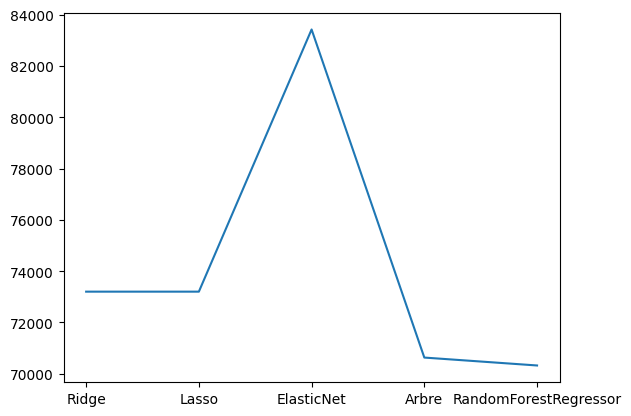

In [39]:
plt.plot(nnn, rrr)

### Modele pour les locaux industriels

In [40]:
df3 = df[['Surface reelle bati', 'Surface terrain', 'Surface', 'metre carre', 'Valeur fonciere', 'total', 'Code departement', 'Type local']][df['Type local'].isin(['Local industriel. commercial ou assimilé'])]
df3.shape

(126767, 8)

In [41]:
df3.isna().sum()

Surface reelle bati     2217
Surface terrain        74025
Surface                    0
metre carre                0
Valeur fonciere            0
total                      0
Code departement           0
Type local                 0
dtype: int64

In [42]:
df3.dtypes

Surface reelle bati    float64
Surface terrain        float64
Surface                 object
metre carre            float64
Valeur fonciere        float64
total                  float64
Code departement        object
Type local              object
dtype: object

In [43]:
df3 = df3[df3['Surface reelle bati'].notna()]

In [44]:
df3.shape

(124550, 8)

In [45]:
for col in df3.select_dtypes(exclude='object'):
    q1 = df3[col].quantile(q=0.25)
    q3 = df3[col].quantile(q=0.75)

    IQR = q3 - q1

    borne_inf = q1 - 1.5 * IQR
    borne_sup = q3 + 1.5 * IQR

    df3 = df3[df3[col] < borne_sup]
    df3 = df3[df3[col] > borne_inf]

    df3[col].fillna(df3[col].median(), inplace=True)
df3.shape

(29626, 8)

In [46]:
df3.select_dtypes(exclude='object').corr()

,Surface reelle bati,Surface terrain,metre carre,Valeur fonciere,total
Surface reelle bati,1.000000,0.506421,-0.044392,0.303341,-0.031600
Surface terrain,0.506421,1.000000,-0.045761,0.246713,-0.057595
metre carre,-0.044392,-0.045761,1.000000,0.345359,0.733706
Valeur fonciere,0.303341,0.246713,0.345359,1.000000,0.281956
total,-0.031600,-0.057595,0.733706,0.281956,1.000000


In [47]:
df3_ = df3.select_dtypes(exclude='object')

In [48]:
target = 'Valeur fonciere'

In [49]:
X = df3_.drop(target, axis=1)
y = df3_[target]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [51]:
X_train.shape

(20738, 4)

In [52]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [53]:
X_train_sc = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_train_sc.head()

,Surface reelle bati,Surface terrain,metre carre,total
0,-0.623783,-0.091913,-0.848661,-1.002162
1,-0.684565,-0.882458,-1.104160,-1.158143
2,-0.040276,-0.736791,-1.085144,-0.525003
3,0.439901,-0.053979,0.999068,1.441625
4,-0.483984,0.730496,-0.384293,-0.376489


In [54]:
X_test_sc = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [55]:
models = [
    ('Ridge', Ridge(alpha=0.75)),
    ('Lasso', Lasso(alpha=10)),
    ('ElasticNet', ElasticNet(alpha=10, l1_ratio=0.8)),
    ('Arbre', DecisionTreeRegressor(max_depth=9, min_samples_leaf=5, min_samples_split=200, random_state=0)),
    ('RandomForestRegressor', RandomForestRegressor(max_depth=9, min_samples_leaf=5, min_samples_split=400, n_estimators=150, random_state=0)),
]

In [56]:
RMSEs = []

In [57]:
for name, model in models:
    model.fit(X_train_sc, y_train)

    # Prédisez les valeurs sur l'ensemble de test avec le meilleur modèle
    ypred = model.predict(X_test_sc)

    # Évaluez les performances du modèle (par exemple, avec la MSE)
    rmse = math.sqrt(mean_squared_error(y_test, ypred))
    r2Score = r2_score(y_test, ypred)
    RMSEs.append({'name': name, 'rmse': rmse, 'r2': r2Score})
    print(f"Modèle: {name}")
    print(f"Mean Squared Error: {rmse}")
    print(f"R2: {r2Score}")
    print("---------")

Modèle: Ridge
Mean Squared Error: 106693.65729389469
R2: 0.22723287270239312
---------


Modèle: Lasso
Mean Squared Error: 106693.54154976604
R2: 0.22723454933831577
---------
Modèle: ElasticNet
Mean Squared Error: 111741.36157598779
R2: 0.1523835968246271
---------
Modèle: Arbre
Mean Squared Error: 106843.05118080397
R2: 0.22506727986867692
---------
Modèle: RandomForestRegressor
Mean Squared Error: 104896.2893974161
R2: 0.25304973415916787
---------


In [58]:
rrr = []
nnn = []
for rmse in RMSEs:
    rrr.append(rmse['rmse'])
    nnn.append(rmse['name'])


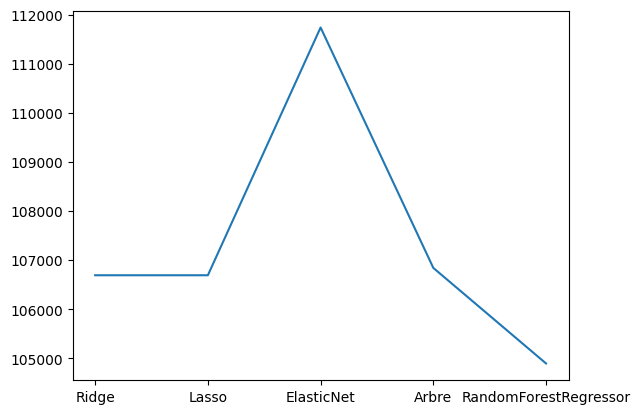

In [59]:
plt.plot(nnn, rrr)

In [60]:
arbreParams ={"splitter":["best","random"],
            "max_depth" : [1,3,5,],
           "min_samples_leaf":[2,4,6,8,10],
           "min_weight_fraction_leaf":[0.2,0.4,0.8],
           "max_features":["auto","log2","sqrt"],
           "max_leaf_nodes":[10,20, 40, 60, 90] }

In [61]:
grid_search = GridSearchCV(DecisionTreeRegressor(), arbreParams, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train_sc, y_train)

/Users/moise/Documents/projects/m2-sise/ml-python/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
2250 fits failed out of a total of 4050.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1350 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/moise/Documents/projects/m2-sise/ml-python/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/moise/Documents/projects/m2-sise/ml-python/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/moise/Documents/projects/m2-sise/ml-pyt

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 3, 5],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'max_leaf_nodes': [10, 20, 40, 60, 90],
                         'min_samples_leaf': [2, 4, 6, 8, 10],
                         'min_weight_fraction_leaf': [0.2, 0.4, 0.8],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_squared_error')

In [62]:
# Meilleur modèle trouvé avec la meilleure valeur d'alpha
best_model = grid_search.best_estimator_

In [63]:
# Prédisez les valeurs sur l'ensemble de test avec le meilleur modèle
ypred = best_model.predict(X_test_sc)

# Évaluez les performances du modèle (par exemple, avec la MSE)
rmse = math.sqrt(mean_squared_error(y_test, ypred))
r2Score = r2_score(y_test, ypred)
print(rmse, )

113645.72662381743


In [64]:
df4 = df[['Surface reelle bati', 'metre carre', 'Valeur fonciere', 'total', 'Code departement', 'Type local']][df['Type local'].isin(['Dépendance'])]
df4.shape

(223310, 6)

In [65]:
df4.isna().sum()

Surface reelle bati    4
metre carre            0
Valeur fonciere        0
total                  0
Code departement       0
Type local             0
dtype: int64

In [66]:
df4.head()

,Surface reelle bati,metre carre,Valeur fonciere,total,Code departement,Type local
12,0.0,2294.079592,169000.0,647634.0,01,Dépendance
46,0.0,2294.079592,35000.0,647634.0,01,Dépendance
74,0.0,2294.079592,11000.0,647634.0,01,Dépendance
88,0.0,2294.079592,11500.0,647634.0,01,Dépendance
90,0.0,2294.079592,12000.0,647634.0,01,Dépendance


In [67]:
df4['Surface reelle bati'].sort_values()

12         0.0
1657749    0.0
1657750    0.0
1657757    0.0
1657760    0.0
          ... 
2273399    0.0
562608     NaN
563609     NaN
764507     NaN
877162     NaN
Name: Surface reelle bati, Length: 223310, dtype: float64

In [68]:
df4.select_dtypes(exclude='object').corr()

,Surface reelle bati,metre carre,Valeur fonciere,total
Surface reelle bati,NaN,NaN,NaN,NaN
metre carre,NaN,1.000000,0.088148,0.583639
Valeur fonciere,NaN,0.088148,1.000000,0.076756
total,NaN,0.583639,0.076756,1.000000


In [69]:
for col in df4.select_dtypes(exclude='object'):
    q1 = df4[col].quantile(q=0.25)
    q3 = df4[col].quantile(q=0.75)

    IQR = q3 - q1

    borne_inf = q1 - 1.5 * IQR
    borne_sup = q3 + 1.5 * IQR

    df4 = df4[df4[col] < borne_sup]
    df4 = df4[df4[col] > borne_inf]

    df4[col].fillna(df4[col].median(), inplace=True)
df4.shape

(0, 6)

In [70]:
df4.select_dtypes(exclude='object').corr()

,Surface reelle bati,metre carre,Valeur fonciere,total
Surface reelle bati,NaN,NaN,NaN,NaN
metre carre,NaN,NaN,NaN,NaN
Valeur fonciere,NaN,NaN,NaN,NaN
total,NaN,NaN,NaN,NaN


In [71]:
df3_ = df3.select_dtypes(exclude='object')

In [72]:
target = 'Valeur fonciere'

In [73]:
X = df3_.drop(target, axis=1)
y = df3_[target]

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [75]:
X_train.shape

(20738, 4)

In [76]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [77]:
X_train_sc = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_train_sc.head()

,Surface reelle bati,Surface terrain,metre carre,total
0,-0.623783,-0.091913,-0.848661,-1.002162
1,-0.684565,-0.882458,-1.104160,-1.158143
2,-0.040276,-0.736791,-1.085144,-0.525003
3,0.439901,-0.053979,0.999068,1.441625
4,-0.483984,0.730496,-0.384293,-0.376489


In [78]:
X_test_sc = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [79]:
models = [
    ('Ridge', Ridge(alpha=0.75)),
    ('Lasso', Lasso(alpha=10)),
    ('ElasticNet', ElasticNet(alpha=10, l1_ratio=0.8)),
    ('Arbre', DecisionTreeRegressor(max_depth=9, min_samples_leaf=5, min_samples_split=200, random_state=0)),
    ('RandomForestRegressor', RandomForestRegressor(max_depth=9, min_samples_leaf=5, min_samples_split=400, n_estimators=150, random_state=0)),
]

In [80]:
RMSEs = []

In [81]:
for name, model in models:
    model.fit(X_train_sc, y_train)

    # Prédisez les valeurs sur l'ensemble de test avec le meilleur modèle
    ypred = model.predict(X_test_sc)

    # Évaluez les performances du modèle (par exemple, avec la MSE)
    rmse = math.sqrt(mean_squared_error(y_test, ypred))
    r2Score = r2_score(y_test, ypred)
    RMSEs.append({'name': name, 'rmse': rmse, 'r2': r2Score})
    print(f"Modèle: {name}")
    print(f"Mean Squared Error: {rmse}")
    print(f"R2: {r2Score}")
    print("---------")

Modèle: Ridge
Mean Squared Error: 106693.65729389469
R2: 0.22723287270239312
---------


Modèle: Lasso
Mean Squared Error: 106693.54154976604
R2: 0.22723454933831577
---------
Modèle: ElasticNet
Mean Squared Error: 111741.36157598779
R2: 0.1523835968246271
---------
Modèle: Arbre
Mean Squared Error: 106843.05118080397
R2: 0.22506727986867692
---------
Modèle: RandomForestRegressor
Mean Squared Error: 104896.2893974161
R2: 0.25304973415916787
---------


In [82]:
rrr = []
nnn = []
for rmse in RMSEs:
    rrr.append(rmse['rmse'])
    nnn.append(rmse['name'])


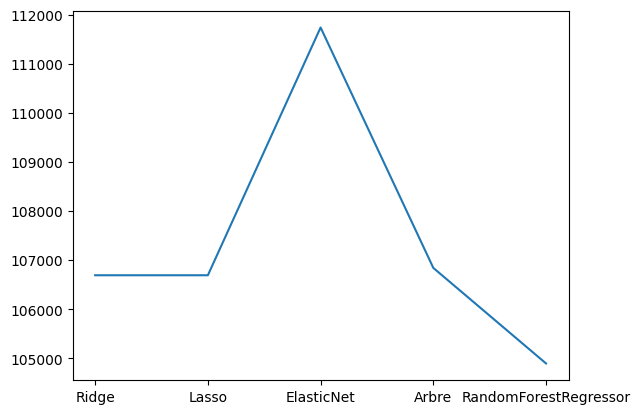

In [83]:
plt.plot(nnn, rrr)

In [84]:
arbreParams ={"splitter":["best","random"],
            "max_depth" : [1,3,5,],
           "min_samples_leaf":[2,4,6,8,10],
           "min_weight_fraction_leaf":[0.2,0.4,0.8],
           "max_features":["auto","log2","sqrt"],
           "max_leaf_nodes":[10,20, 40, 60, 90] }

In [85]:
grid_search = GridSearchCV(DecisionTreeRegressor(), arbreParams, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train_sc, y_train)

/Users/moise/Documents/projects/m2-sise/ml-python/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
2250 fits failed out of a total of 4050.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1350 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/moise/Documents/projects/m2-sise/ml-python/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/moise/Documents/projects/m2-sise/ml-python/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/moise/Documents/projects/m2-sise/ml-pyt

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 3, 5],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'max_leaf_nodes': [10, 20, 40, 60, 90],
                         'min_samples_leaf': [2, 4, 6, 8, 10],
                         'min_weight_fraction_leaf': [0.2, 0.4, 0.8],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_squared_error')

In [86]:
# Meilleur modèle trouvé avec la meilleure valeur d'alpha
best_model = grid_search.best_estimator_

In [87]:
# Prédisez les valeurs sur l'ensemble de test avec le meilleur modèle
ypred = best_model.predict(X_test_sc)

# Évaluez les performances du modèle (par exemple, avec la MSE)
rmse = math.sqrt(mean_squared_error(y_test, ypred))
r2Score = r2_score(y_test, ypred)
print(rmse, )

113906.27354175919


In [88]:
df4 = df[['Surface reelle bati', 'Surface terrain', 'Surface', 'metre carre', 'Valeur fonciere', 'total', 'Code departement', 'Type local']][df['Type local'].isin(['Dépendance'])]
df4.shape

(223310, 8)